# TP 2 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=Int64[]
    weight=Int64[]
    KnapCap=Int64[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:
function testSondability_LP(current_node, BestProfit, Bestsol,afficher)
    TA, TO, TR = false, false, false
    listobjs = current_node[1]
    listvals =  current_node[2]
    (UB,LB ,capacity_courant,x) =  current_node[3]
    if(capacity_courant < 0 )#Test de faisabilite
        #réussi si la capacit´e restante est strictement n´egative
        TA=true
        if afficher
            println("TA")
        end
    elseif(UB <= BestProfit) #Test d'optimalite
        #réussi si BS est pire que la meilleure solution connue
        TO=true
        if afficher
            println("TO")
        end
    elseif(UB == LB)
        #Test de resolution
        #LB=UB, cela implique normalement que tu as toutes tes variables entières et donc que ton test de résolution a réussi. 
        TR=true
        if afficher
            println("TR")
        end
        #if (value(benef) >= BestProfit)
        if (LB >=BestProfit)
            #BestProfit=value(benef)
            Bestsol = x
            BestProfit=LB
            if afficher
                println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
            end
        end
    else
        if afficher
            println("non sondable")
        end
    end
    TA, TO, TR, Bestsol, BestProfit
end

testSondability_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:
function separateNode_borne1!(node_courant,list_nodes,price,weight,capacity,nodes,current_node_number,afficher ,n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    #Chaque nœud est représenté par un tuple qui consigne toutes les informations propres à ce nœud spécifique.
    #Ainsi, nous avons un accès direct aux listobjs et listvals du nœud actuel, lesquels contiennent les objets sur 
    #lesquels nous avons déjà effectué des branches ainsi que les valeurs associées jusqu'à ce point,  et la capacity restant dans ce noeud
    
    listobjs, listvals = node_courant[1],node_courant[2]
    # #################Borne1
    ratios = best_ratio(price, weight)
    i,obj = 1,0
    #Sélectionner la première variable xkxk​ dans l'ordre décroissant des ratios qui n'appartient pas à la liste des objets
    #sur lesquels nous avons déjà effectué des branches.
    while ((i <= n) && (obj==0))
        (ratio,indice) = ratios[i]
        if(!(indice in listobjs))
            obj=indice
        end
 
        i +=1
    end 
    if afficher
        println("\nbranch on object ", obj, "\n")
    end
    #Deux copies de listobjs et listvals sont créées pour conserver les informations du nœud parent. 
    #Cela nous permet d'ajouter à ces informations les détails des deux nœuds enfants, notamment 
    #l'objet sur lequel nous allons effectuer une branche et la valeur attribuée à cet objet dans chaque nœud fils.
    listobjs_left , listobjs_right = copy(listobjs), copy(listobjs)
    listvals_left , listvals_right = copy(listvals),copy(listvals)
    
    
    push!(listobjs_left,obj) #save the identity of the object selected for branching
    push!(listvals_left,1.0) 
    #on calcule la borne1 de ce noeud fils 
    UB = Borne1(price, weight, capacity, listobjs_left, listvals_left,ratios)
     #Le nœud gauche est créé en instanciant un tuple qui contient toutes les informations spécifiques à ce nœud.
    node_left = (listobjs_left, listvals_left, UB)
    
    push!(listobjs_right,obj) #save the identity of the object selected for branching
    push!(listvals_right,0.0)
    #on calcule la borne1 de ce noeud fils 
    UB = Borne1(price, weight, capacity, listobjs_right, listvals_right,ratios)
    # Les nœuds fils créés sont stockés dans list_nodes, ce qui nous permettra de sélectionner le nœud à explorer par la suite.
    node_right =(listobjs_right,listvals_right,UB)
    # Les nœuds fils créés sont stockés dans list_nodes, ce qui nous permettra de sélectionner le nœud à explorer par la suite.
    push!(list_nodes,node_left)
    push!(list_nodes,node_right)
    # La structure de données que nous devons ajouter ici sera utilisée pour représenter graphiquement le graphe. 
    #Elle va stocker des tuples contenant les nœuds fils créés ainsi que le numéro du nœud parent correspondant. 
    #Cela simplifie l'identification du nœud parent pour chaque nœud fils.
    push!(nodes ,(node_left,current_node_number))
    push!(nodes ,(node_right,current_node_number))
    
end



#Nous implémentons ici une stratégie d'exploration qui accorde la priorité au nœud possédant la plus grande borne supérieure
function exploreNextNode!(list_nodes)
   #list_nodes contient les noeuds non explorer

    stop=false
    # verifier s il reste des noeuds a explorer ou non
    if isempty(list_nodes)
        return true, nothing
    else
        # on cherche le noeud ayant la plus grand borne sup
        next_node=reduce(list_nodes) do x,y x[3]>y[3] ? x : y end
        index_a_supprimer = findfirst(x -> x == next_node, list_nodes)
        #on supprime le noeud choisé
        deleteat!(list_nodes, index_a_supprimer)
        return false ,next_node
    end
 
end







exploreNextNode! (generic function with 1 method)

In [5]:
function separateNode_borne2!(node_courant,list_nodes,price,weight,capacity,nodes,current_node_number,afficher, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes

    #Chaque nœud est représenté par un tuple qui consigne toutes les informations propres à ce nœud spécifique.
    #Ainsi, nous avons un accès direct aux listobjs et listvals du nœud actuel, lesquels contiennent les objets sur 
    #lesquels nous avons déjà effectué des branches ainsi que les valeurs associées jusqu'à ce point,  et la capacity restant dans ce noeud
    
    listobjs, listvals = node_courant[1],node_courant[2]
    # #################Borne2
    # Recherche de la première valeur non entière dans x
    #Brancher sur la variable la plus fractionnaire 
    #node_courant[3][4] contient la solution trouvée pour le noeud courant 
    obj = findfirst(x -> x <1 && x>0, node_courant[3][4])
    ratios = best_ratio(price, weight)

    if afficher
        println("\nbranch on object ", obj, "\n")
    end

    #Deux copies de listobjs et listvals sont créées pour conserver les informations du nœud parent. 
    #Cela nous permet d'ajouter à ces informations les détails des deux nœuds enfants, notamment 
    #l'objet sur lequel nous allons effectuer une branche et la valeur attribuée à cet objet dans chaque nœud fils.
    listobjs_left , listobjs_right = copy(listobjs), copy(listobjs)
    listvals_left , listvals_right = copy(listvals),copy(listvals)
    
    
    push!(listobjs_left,obj) #save the identity of the object selected for branching
    push!(listvals_left,1.0) 
    #on calcule la borne2 de ce noeud fils 
    UB = Borne2(price, weight, capacity, listobjs_left, listvals_left,ratios)
    # Le nœud gauche est créé en instanciant un tuple qui contient toutes les informations spécifiques à ce nœud.
    node_left = (listobjs_left, listvals_left, UB)
    
    push!(listobjs_right,obj) #save the identity of the object selected for branching
    push!(listvals_right,0.0)
    #on calcule la borne2 de ce noeud fils 
    UB = Borne2(price, weight, capacity, listobjs_right, listvals_right,ratios)
    # Le nœud droite est créé en instanciant un tuple qui contient toutes les informations spécifiques à ce nœud.
    node_right =(listobjs_right,listvals_right,UB)
    # Les nœuds fils créés sont stockés dans list_nodes, ce qui nous permettra de sélectionner le nœud à explorer par la suite.
    push!(list_nodes,node_left)
    push!(list_nodes,node_right)
    # La structure de données que nous devons ajouter ici sera utilisée pour représenter graphiquement le graphe. 
    #Elle va stocker des tuples contenant les nœuds fils créés ainsi que le numéro du nœud parent correspondant. 
    #Cela simplifie l'identification du nœud parent pour chaque nœud fils.
    push!(nodes ,(node_left,current_node_number))
    push!(nodes ,(node_right,current_node_number))
    
end

separateNode_borne2! (generic function with 1 method)

In [6]:
# Cette fonction, Borne2, essaie de trouver une borne supérieure et une borne inférieure pour le problème d'optimisation
# Elle prend en compte la liste d'objets possibles, leurs poids, leurs valeurs, une capacité, et une liste de meilleurs ratios

function Borne2(price, weight, capacity,listobjs,listvals,list_best_ratio)
    j =1
    entrer = true 
    x=Float64[0 for i = 1:length(weight)]
    # Parcours des objets de la liste d'objets
    for i in listobjs
        # Réduction de la capacité en fonction du poids de l'objet et de sa valeur
        capacity =  capacity - weight[i]*listvals[j]
        x[i] = listvals[j]    # Attribution de la valeur à l'objet dans la solution x
        j+=1
    end 
     # Vérification de la capacité restante après avoir pris les objets de la liste
    if capacity < 0
        entrer = false  # Si la capacité est négative, aucun ajout d'objet supplémentaire n'est possible
    end
    # Parcours des meilleurs ratios pour ajouter les objets non inclus dans la liste d'objets
    i = 1
    while (i <= length(list_best_ratio))&&entrer
        (ratio,k)  =  list_best_ratio[i]
        if !(k in listobjs)
            if weight[k] <= capacity
                x[k] = 1 # Si le poids de l'objet peut être inclus dans la capacité restante, il est ajouté entièrement
                capacity =  capacity - weight[k]
            else 
               
                if capacity != 0
                    x[k] = capacity/weight[k]  # Fraction de l'objet ajoutée si la capacité ne permet pas l'ajout complet
                    capacity = 0
                else 
                    x[k] = 0   # Sinon, l'objet ne peut pas être ajouté
                end 
            end 
        end
        i+=1
    end 
    # Calcul des bornes supérieure (UB) et inférieure (LB) en fonction de la solution obtenue
    UB = sum(price.*x)
    index = findfirst(x -> x <1&& x>0, x) # Recherche de la première valeur non entière dans x
    
    l = copy(x)
    
    if index != nothing
        l[index] = 0  # Si une valeur non entière est trouvée, elle est retirée pour obtenir une borne inférieure
    end

    LB = sum(price.*l) # Borne inférieure

    return UB,LB,capacity,x
    
    
end 


# Cette fonction, best_ratio, calcule les ratios (valeur/poids) pour chaque objet et les classe par ordre décroissant
function best_ratio(price, weight)
    ratio = []
    x=[0 for i = 1:length(weight)]
    # Calcul des ratios pour chaque objet
    for i in 1:length(weight)
        ratioi = price[i]/weight[i]
        # Stockage du ratio et de l'indice de l'objet correspondant
        push!(ratio,(ratioi,i)) 
    end
    # Classement des ratios par ordre décroissant
    ratio = sort(ratio, by = x -> x[1],rev=true) 
    # Retourne la liste des ratios triés
    return ratio 
end   
# Cette fonction, Borne1, cherche également des bornes pour le problème d'optimisation, mais d'une manière différente
function Borne1(price, weight, capacity, listobjs, listvals,list_best_ratio)
    obj =0 
    x_bar = 0
    UB = 0
    LB =0
    # Recherche de l'objet non inclus dans la liste d'objets en parcourant la liste des ratios triés en respectant l'ordre
    #pour l'utiliser comme point de départ
    #choisir la 1`ere variable fractionnaire xk dans l’ordre décroissant du ratio pour touver le x qui va jouer le role de x bar noté dans 
    #le cours
    for (ratio , i) in list_best_ratio
        if !(i in listobjs)
            obj = i 
            break
        end
    end
    x=[0 for i = 1:length(weight)]
    # Calcul des bornes en fonction de l'objet trouvé ou non
    if obj != 0 
        #on teste si on est dans le noeud pere ou non
        if (length(listobjs)>= 1)
            j=1
            # Si la liste d'objets n'est pas vide, les objets inclus sont ajoutés et la capacité est mise à jour
            for i in listobjs
                capacity -= weight[i]*listvals[j]
                UB += price[i]*listvals[j]
                LB += price[i]*listvals[j]
                x[i] = listvals[j]
                j+=1
            end 
            # on calcule le x_bar 
            x_bar = capacity/weight[obj]
            UB += price[obj]*x_bar
        else
            # si on est a la racine on calcule le x_bar directement
            x_bar = capacity/weight[obj]
            UB = price[obj]*x_bar
        end
    else
        #ce blog sera executé dans le dernier noeud qui va donner une solution realisable
            j=1
            for i in listobjs
                capacity -= weight[i]*listvals[j]
                UB += price[i]*listvals[j]
                LB += price[i]*listvals[j]
                x[i] = listvals[j]
                j+=1
            end 
    end
    # retourne la borne sup , la borne inf , la capacity restant dans ce noeud et les valeurs des variables binaires x
    return UB,LB,capacity,x
end










  
    
   
 


Borne1 (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [7]:
function solveKnapInstance(filename,choixBorne,afficher)

    price, weight, capacity = readKnaptxtInstance(filename)



    capacite_courant = 0

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree
    
    #intermediate structure to navigate in the search tree
    listobjs=Int64[]
    listvals=Float64[]
    listnodes=[]

    BestProfit::Float64=-1.0
    Bestsol=Float64[]

    current_node_number::Int64=0
    stop = false
    #  creer le noeud pere
    list_best_ratio = best_ratio(price, weight)
    if choixBorne == "Borne2"
        uplet = Borne2(price, weight, capacity, listobjs, listvals,list_best_ratio)
    else 
        uplet = Borne1(price, weight, capacity, listobjs, listvals,list_best_ratio)
    end 
    
    Bestsol = Float64[]
    #La structure de données qui va stocker tous les nœuds créés sera une liste
    #qui contiendrait l'ensemble des nœuds générés pendant le processus. 
    nodes = []
    # la racine 
    node0 = ([],[],uplet)
    # le noeud courant 
    current_node = node0
    #stocker le prochain noeud a explorer
    next_node =  node0

    

    while(!stop)
        if afficher
            println("\nNode number ", current_node_number, ": \n---------------\n")
        end
        current_node = next_node
        

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            # on cherche dans liste listnodes l indice de du noeud courant pour trouver le nom du noeud pére 
            index_a_ajouter = findfirst(x -> x[1] == current_node, listnodes)
            push!(trParentnodes,listnodes[index_a_ajouter][2]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
            
            deleteat!(listnodes, index_a_ajouter)
            
        end
        


        

        #println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

        TA, TO, TR, Bestsol, BestProfit = testSondability_LP(current_node , BestProfit, Bestsol,afficher)

        is_node_sondable = TA || TO || TR

       
        # créer les noeuds fils si le noeud courant est non sonadable
        if(!is_node_sondable)
            
            if choixBorne == "Borne2"
                separateNode_borne2!(current_node,nodes,price,weight,capacity,listnodes,current_node_number,afficher, length(price))
            else
                separateNode_borne1!(current_node,nodes,price,weight,capacity,listnodes,current_node_number,afficher, length(price))
            end
            
            
        end
        # choisir le noeud suivant à explorer 
        stop , next_node = exploreNextNode!(nodes)

        current_node_number = current_node_number + 1
    end
    if afficher
        println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
    end
    

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end



solveKnapInstance (generic function with 1 method)

### Affichage du résultat final

In [8]:
function solveNdisplayKnap(filename,borne)

    println("\n Branch-and-Bound for solving a knapsack problem. \n\n Solving instance '" * filename * "'\n")

    BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = solveKnapInstance(filename,borne,true)

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    println("\n Branch-and-bound tree visualization : start display ...")
    display(graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree))
    println("... end display. \n\n")

end

solveNdisplayKnap (generic function with 1 method)


 Branch-and-Bound for solving a knapsack problem. 

 Solving instance 'InstancesKnapSack/test.opb.txt'


Node number 0: 
---------------

non sondable

branch on object 2


Node number 1: 
---------------

non sondable

branch on object 1


Node number 2: 
---------------

TA

Node number 3: 
---------------

non sondable

branch on object 4


Node number 4: 
---------------

non sondable

branch on object 3


Node number 5: 
---------------

TA

Node number 6: 
---------------

TR

New Solution memorized [0, 1, 0, 1] with bestprofit 65.0


Node number 7: 
---------------

TO

Node number 8: 
---------------

TO

******

Optimal value = 65.0

Optimal x=[0, 1, 0, 1]

******

Optimal value = 65.0

Optimal x=[0, 1, 0, 1]

 Branch-and-bound tree visualization : start display ...


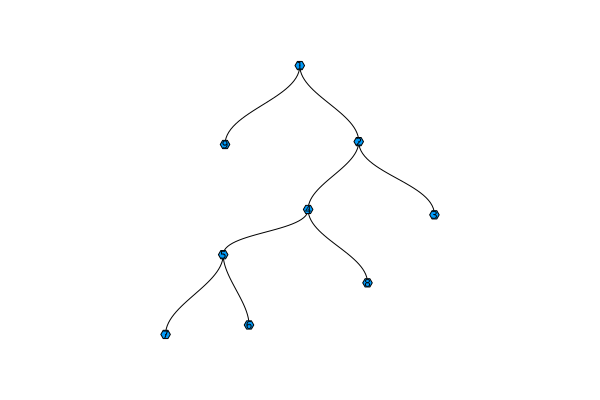

... end display. 


press enter to exit ! 


stdin>  


""

In [11]:
INSTANCE = "InstancesKnapSack/test.opb.txt"

solveNdisplayKnap(INSTANCE,"Borne1")

println("press enter to exit ! ")
readline()


# Questions préliminaires


1.La méthode de séparation repose sur un critère lexicographique, impliquant le parcours séquentiel des objets dans un ordre spécifique pour choisir le premier objet non encore fexé.

2.La méthode utilisée pour calculer la borne supérieure à chaque nœud est dérivée du coût de la solution du problème de relaxation associé à ce nœud spécifique.

3.les tests utilisés sont :
1. TA  : Ce test est vérifié si le statut de terminaison (termination_status(model2)) du modèle est déclaré comme étant INFEASIBLE. Cela signifie que le modèle est jugé non réalisable.
2. TO  : Ce test est vérifié si la valeur de l'objectif actuel (objective_value(model2)) est inférieure ou égale à la meilleure valeur de profit jusqu'à présent (BestProfit). Cela vise à déterminer si la solution actuelle est optimale ou si une meilleure solution a déjà été trouvée.
3. TR : Ce test est vérifié si la solution optimale  du problème de relaxation est réalisable
pour le problème de départ .

4.La méthode d'exploration adoptée, le parcours en profondeur, implique une exploration approfondie d'une branche avant de passer à une autre. Lorsqu'il s'agit de choisir entre les deux nouveaux fils créés à partir de la séparation, le code privilégie systématiquement celui situé le plus à gauche pour poursuivre l'exploration.

# les testes utilisés

1."InstancesKnapSack/almost_strongly_correlated/knapPI_5_100_1000_1_-2295.opb.txt" 

2."InstancesKnapSack/circle/knapPI_16_100_1000_1_-4400.opb.txt" 

3."InstancesKnapSack/inverse_strongly_correlated/knapPI_4_50_1000_1_-994.opb.txt" 

4."InstancesKnapSack/inverse_strongly_correlated/knapPI_4_100_1000_1_-997.opb.txt" 

5."InstancesKnapSack/multiple_strongly_correlated/knapPI_14_20_1000_2_-1743.opb.txt" 

6."InstancesKnapSack/similar_weights/knapPI_9_100_1000_1_-995.opb.txt" 

7."InstancesKnapSack/subset_sum/knapPI_6_100_1000_1_-997.opb.txt" 

8."InstancesKnapSack/uncorrelated/knapPI_1_100_1000_1_-9147.opb.txt" 

9."InstancesKnapSack/weakly_correlated/knapPI_2_100_1000_1_-1514.opb.txt" 

10."InstancesKnapSack/weakly_correlated_span/knapPI_12_100_1000_1_-970.opb.txt"

11."InstancesKnapSack/multiple_strongly_correlated/knapPI_14_20_1000_1_-1794.opb.txt"

12."InstancesKnapSack/profit_ceiling/knapPI_15_20_1000_1_-999.opb.txt"

13."InstancesKnapSack/profit_ceiling/knapPI_15_20_1000_3_-1002.opb.txt"

14."InstancesKnapSack/multiple_strongly_correlated/knapPI_14_20_1000_1_-1794.opb.txt"

15."InstancesKnapSack/strongly_correlated_span/knapPI_13_20_1000_4_-907.opb.txt"

16."InstancesKnapSack/uncorrelated_span/knapPI_11_20_1000_1_-1428.opb.txt"


# Code et analyse

# Question 4


1.Pour stocker les informations des nœuds, nous avons opté pour l'utilisation de tuples. Chaque tuple contient listobjets et listvals, indiquant les variables sur lesquelles des branchements ont été effectués et les valeurs associées à ces variables jusqu'au nœud courant. De plus, le tuple inclut la borne supérieure, la borne inférieure, la capacité restante dans ce nœud, et la solution courante. Cette approche simplifie la gestion des nœuds. Par exemple, lors des tests de sondabilité, il suffit de fournir en paramètre à une fonction le nœud courant, et nous pouvons obtenir la capacité actuelle pour effectuer le test d'admissibilité, la borne supérieure pour le test d'optimalité, et la solution courante pour le test de résolution.


2.Pour conserver les nœuds non explorés, nous utilisons une liste. Lorsque nous choisissons un nœud à explorer, nous recherchons dans cette liste le nœud ayant la plus grande borne supérieure, puis nous le supprimons de la liste.

3.Pour représenter graphiquement l'arbre, nous avons également utilisé une liste de tuples. Chaque tuple stocke le nom du nœud parent et le nœud fils créé. Cela facilite la localisation du nœud courant dans la fonction principale en recherchant dans la liste le nœud actuel associé au nom de son parent pour l'ajouter à trParentnodes.

4.BORNE1 : 
Nous commençons par trier les objets par ordre décroissant en fonction de leur ratio (ratio $r_i = c_i/w_i$ ). Ensuite, nous recherchons le premier objet rencontré dans cette liste triée qui n'appartient pas à listeobjets. Après avoir trouvé cet objet, nous parcourons la liste listeobjets pour ajuster la capacité, puis nous calculons $\bar{x_i}=w_i/capacityrestant$. En utilisant cette valeur, nous obtenons les estimations UB et LB.

5.BORNE2 : 
Nous entamons en parcourant la listeobjets pour réduire la capacité en fonction du poids de l'objet et de sa valeur. Une fois que nous avons déterminé la capacité disponible, nous passons à la liste d'objets triée par ordre décroissant selon leur ratio $(r_i = \frac{c_i}{w_i}$). Nous effectuons une série de tests pour vérifier si l'objet appartient déjà à listeobjets. Si ce n'est pas le cas, nous comparons son poids ($w_i$) avec la capacité restante. Si le poids de l'objet peut être inclus dans la capacité restante, il est ajouté entièrement  sinon, nous ajoutons une fraction de cet objet si la capacité disponible ne permet pas l'ajout complet.


#  Question 5

In [12]:
choixborne = ["Borne1","Borne2"]
tests = ["InstancesKnapSack/strongly_correlated_span/knapPI_13_20_1000_4_-907.opb.txt",
"InstancesKnapSack/uncorrelated_span/knapPI_11_20_1000_1_-1428.opb.txt",
"InstancesKnapSack/almost_strongly_correlated/knapPI_5_100_1000_1_-2295.opb.txt",
"InstancesKnapSack/circle/knapPI_16_100_1000_1_-4400.opb.txt",
"InstancesKnapSack/inverse_strongly_correlated/knapPI_4_50_1000_1_-994.opb.txt",
"InstancesKnapSack/inverse_strongly_correlated/knapPI_4_100_1000_1_-997.opb.txt",
"InstancesKnapSack/similar_weights/knapPI_9_100_1000_1_-995.opb.txt",
"InstancesKnapSack/subset_sum/knapPI_6_100_1000_1_-997.opb.txt",
"InstancesKnapSack/uncorrelated/knapPI_1_100_1000_1_-9147.opb.txt",
"InstancesKnapSack/weakly_correlated/knapPI_2_100_1000_1_-1514.opb.txt",
"InstancesKnapSack/weakly_correlated_span/knapPI_12_100_1000_1_-970.opb.txt",
"InstancesKnapSack/multiple_strongly_correlated/knapPI_14_20_1000_1_-1794.opb.txt",
"InstancesKnapSack/profit_ceiling/knapPI_15_20_1000_1_-999.opb.txt",
"InstancesKnapSack/profit_ceiling/knapPI_15_20_1000_3_-1002.opb.txt"
]

for borne in choixborne
    println("-------------------------------------------------------------------------")
    printstyled("choixborne  : ",borne, ":\n", bold=true, color=:red)
    for test in tests 

        debut = time()
        BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = solveKnapInstance(test,borne,false)
        fin = time()
        temps_calcul = fin-debut
        
        printstyled("teste  : ",test, ":\n", bold=false, color=:green)
        println("---solution : ",BestProfit,"  --- nbde_noeud : ",length(trNamenodes)," ---- temps de calcul : ",temps_calcul)
    end

end
        

-------------------------------------------------------------------------
choixborne  : Borne1:
teste  : InstancesKnapSack/strongly_correlated_span/knapPI_13_20_1000_4_-907.opb.txt:
---solution : 1404.0  --- nbde_noeud : 2009 ---- temps de calcul : 0.20839905738830566
teste  : InstancesKnapSack/uncorrelated_span/knapPI_11_20_1000_1_-1428.opb.txt:
---solution : 1428.0  --- nbde_noeud : 559 ---- temps de calcul : 0.010497808456420898
teste  : InstancesKnapSack/almost_strongly_correlated/knapPI_5_100_1000_1_-2295.opb.txt:
---solution : 2295.0  --- nbde_noeud : 3101 ---- temps de calcul : 0.32052111625671387
teste  : InstancesKnapSack/circle/knapPI_16_100_1000_1_-4400.opb.txt:
---solution : 4400.0  --- nbde_noeud : 1253 ---- temps de calcul : 0.0649099349975586
teste  : InstancesKnapSack/inverse_strongly_correlated/knapPI_4_50_1000_1_-994.opb.txt:
---solution : 994.0  --- nbde_noeud : 3 ---- temps de calcul : 9.703636169433594e-5
teste  : InstancesKnapSack/inverse_strongly_correlated/knapP

# Analyse :

    Pour la plupart des instances de problème, la borne 2 semble avoir utilisé moins de nœuds dans l'arbre de recherche que la borne 1, ce qui indique un potentiel d'élagage plus efficace des branches dans la recherche avec la borne 2.
    De plus, dans certains cas, la borne 2 a utilisé significativement moins de temps de calcul que la borne 1 pour obtenir la même solution ou une solution de qualité similaire, ce qui pourrait indiquer une meilleure efficacité temporelle dans certains cas.